In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
hw_prefix = '/content/drive/MyDrive/nlp2022-hw1-main/nlp2022-hw1-main/hw1/stud'
hw_prefix = '.'
import string

import numpy as np
from typing import List, Tuple
import sklearn
from torchcrf import CRF
from typing import List, Dict
import json
import torch
import random
import csv
import matplotlib.pyplot as plt
import nltk
from torch import nn
from torch.utils.data import Dataset, DataLoader
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from string import punctuation
from collections import defaultdict
from functools import partial
from seqeval.metrics import accuracy_score, f1_score
import seqeval
torch.manual_seed(42)
np.random.seed(42)
random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
stop_tokens = set(stopwords.words('english'))
punc_tokens = set(punctuation)
stop_tokens.update(punc_tokens)
lemmatizer = WordNetLemmatizer()

#setting the embedding dimension
EMBEDDING_DIM=100
POS_EMBEDDING_DIM=10

#specify the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)
#setting unknown token  to handle out of vocabulary words
UNK_TOKEN = '<unk>'
PAD_TOKEN = '<pad>'
TRAIN_PATH = hw_prefix+"/../../data/train.tsv"
DEV_PATH = hw_prefix+"/../../data/dev.tsv"


cuda


[nltk_data] Downloading package omw-1.4 to /home/michele/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/michele/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/michele/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/michele/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/michele/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
from nltk.data import load
nltk.download("tagsets")
tagdict = load('help/tagsets/upenn_tagset.pickle')
tagdict.keys()
tagdict

[nltk_data] Downloading package tagsets to /home/michele/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


{'LS': ('list item marker',
  'A A. B B. C C. D E F First G H I J K One SP-44001 SP-44002 SP-44005 SP-44007 Second Third Three Two * a b c d first five four one six three two '),
 'TO': ('"to" as preposition or infinitive marker', 'to '),
 'VBN': ('verb, past participle',
  'multihulled dilapidated aerosolized chaired languished panelized used experimented flourished imitated reunifed factored condensed sheared unsettled primed dubbed desired ... '),
 "''": ('closing quotation mark', "' '' "),
 'WP': ('WH-pronoun',
  'that what whatever whatsoever which who whom whosoever '),
 'UH': ('interjection',
  'Goodbye Goody Gosh Wow Jeepers Jee-sus Hubba Hey Kee-reist Oops amen huh howdy uh dammit whammo shucks heck anyways whodunnit honey golly man baby diddle hush sonuvabitch ... '),
 'VBG': ('verb, present participle or gerund',
  "telegraphing stirring focusing angering judging stalling lactating hankerin' alleging veering capping approaching traveling besieging encrypting interrupting era

In [4]:
#creating a vocabulary with glove embeddings
def create_glove(embedding_dim=EMBEDDING_DIM):
    f = open(hw_prefix+'/glove/glove.6B.' + str(embedding_dim) + 'd.txt', 'r')
    glove = {}
    for line in f:
        splitLines = line.split()
        word = splitLines[0]
        embedding = np.array([float(value) for value in splitLines[1:]])
        glove[word] = embedding
    return glove

#creating a vector of word embeddings and a dictionary to pair each word with an index
#the vector of embeddings will be needed in the embedding layer of the neural network
def create_embeddings(vocabulary,embedding_dim=EMBEDDING_DIM):
    vectors = []                                #creating a vector to append the vectors corresponding to words
    word2idx = dict()                           #creating a dictionary to associate each word with an index
    vectors.append(torch.rand(embedding_dim))   #creating a random vector for unknown (out of vocabulary) words
    vectors.append(torch.rand(embedding_dim))   #creating a random vector for padding
    word2idx[UNK_TOKEN] = 0                     #setting the index of the unknown token to 0
    for word,vector in vocabulary.items():      #creating the word:index entry and insert in vectors
        word2idx[word] = len(vectors)           #the word vector at the corresponding index for each word
        vectors.append(torch.tensor(vector))    #in the dictionary
        #vectors.append(torch.rand(embedding_dim))
    word2idx = defaultdict(lambda: 0, word2idx) #if the word we're looking for is not in the dictionary, we give the unknown token index
    vectors = torch.stack(vectors).to(device).float()   #convert the list of tensors into a tensor of tensors
    return vectors,word2idx


def create_pos_embeddings(vocabulary,embedding_dim=POS_EMBEDDING_DIM):
    vectors = []                                #creating a vector to append the vectors corresponding to words
    word2idx = dict()                           #creating a dictionary to associate each word with an index
    vectors.append(torch.rand(embedding_dim))   #creating a random vector for unknown (out of vocabulary) words
    vectors.append(torch.rand(embedding_dim))   #creating a random vector for padding
    word2idx[UNK_TOKEN] = 0                     #setting the index of the unknown token to 0
    for tag in vocabulary.keys():      #creating the word:index entry and insert in vectors
        word2idx[tag] = len(vectors)           #the word vector at the corresponding index for each word
        vector = torch.rand(embedding_dim)
        #print(vector)
        #print(vectors)
        #while vector in vectors:
        #    vector = torch.rand(embedding_dim)
        vectors.append(vector)
    word2idx = defaultdict(lambda: 0, word2idx) #if the word we're looking for is not in the dictionary, we give the unknown token index
    vectors = torch.stack(vectors).to(device).float()   #convert the list of tensors into a tensor of tensors
    return vectors,word2idx

400003
CREATED VOCABULARY
CREATED MODEL
CREATED TRAIN DATASET
CREATED DEV DATASET
765 18
0.645271949839303
              precision    recall  f1-score   support

        CORP       0.62      0.62      0.62       133
          CW       0.48      0.46      0.47       170
         GRP       0.56      0.69      0.62       190
         LOC       0.80      0.78      0.79       243
         PER       0.86      0.81      0.83       300
        PROD       0.57      0.52      0.54       149

   micro avg       0.68      0.68      0.68      1185
   macro avg       0.65      0.65      0.65      1185
weighted avg       0.68      0.68      0.68      1185

LABELS OCCURRENCES {0: 10240, 1: 300, 2: 243, 3: 190, 4: 133, 5: 149, 6: 170, 7: 329, 8: 153, 9: 377, 10: 119, 11: 87, 12: 261}
PREDICTIONS OCCURRENCES {0: 10182, 1: 284, 2: 233, 3: 232, 4: 133, 5: 135, 6: 160, 7: 316, 8: 148, 9: 458, 10: 113, 11: 99, 12: 258}
[[0.96240234 0.0015625  0.00166016 0.00488281 0.00166016 0.00361328
  0.00488281 0.000976

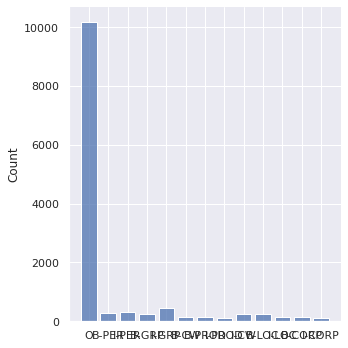

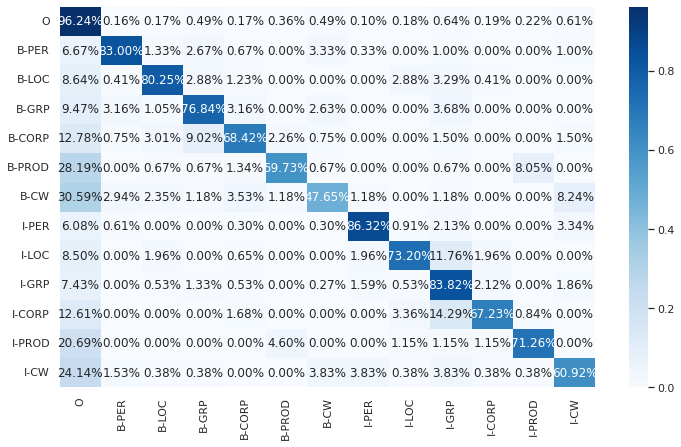

In [57]:
class SentenceDataset(Dataset):

    def __init__(self,vectors,word2idx,pos_vectors,pos2idx,sentences_path=None,sentences=None,lemmatization=False,
                 test=False,class2id={"O": 0, "B-PER": 1, "B-LOC": 2, "B-GRP": 3, "B-CORP": 4, "B-PROD": 5, #indexing output classes
                    "B-CW": 6, "I-PER": 7, "I-LOC": 8, "I-GRP": 9, "I-CORP": 10, "I-PROD": 11, "I-CW": 12, "<pad>":13}):
        file_output = self.read_file(sentences_path) if sentences_path else self.read_sentences(sentences)
        self.embedding_vectors = vectors
        self.word2idx = word2idx
        self.pos_vectors = pos_vectors
        self.pos2idx = pos2idx
        self.test = test
        self.w_lemmatization = lemmatization
        self.word_count = dict()
        self.extract_sentences(file_output)
        #self.remove_most_frequent(percentage=1)
        # encoding of classes
        self.class2id = class2id
        self.id2class = {v: k for (k, v) in self.class2id.items()}

    #function to remove the most frequent words in the corpus (ideally the less discriminative, only acting as noise, but
    #it didn't work great so I'm not sure
    def remove_most_frequent(self,percentage):
        #print("STARTING MOST FREQUENT")
        sorted_counts = sorted(self.word_count.items(),key=lambda x:x[1],reverse=True)  #sort dict with word counts
        total_words = len(sorted_counts)                                                #check the total number of words
        start_index = int((total_words/100)*percentage)                                 #compute the starting point to
        sorted_counts = sorted_counts[start_index:]                                     #exclude the wanted percentage
        sorted_counts = set([x[0] for x in sorted_counts])                              #transforming in set to make
        sentences = []                                                                  #checking the presence efficient (O(1))
        #print("STARTING REMOVING")
        for sample in self.sentences:
            sentence = sample[0]
            new_sentence = []
            for word,pos in sentence:
                if word in sorted_counts:
                    new_sentence.append((word,pos))
            sentences.append((new_sentence,sample[1],sample[2]))
        self.sentences = sentences


    #little function to read a file given the path
    def read_file(self,path):
        sentences = list()
        with open(path) as file:
            tsv_file = csv.reader(file, delimiter="\t")
            for idx,line in enumerate(tsv_file):
                if len(line) > 0:
                    if line[0] == '#':
                        
                        sentences.append(dict())
                        sentences[-1]["id"] = line[2]
                        sentences[-1]["text"] = []
                        sentences[-1]["labels"] = []
                    else:
                        sentences[-1]["text"].append(line[0])
                        sentences[-1]["labels"].append(line[1])
        #print([len(sentences[i]['text']) for i in range(len(sentences))])
        return sentences

    def read_sentences(self,sentences):
        sents = list()
        for idx,line in enumerate(sentences):
            d = dict()
            d["id"] = idx
            d["text"] = line
            d["labels"] = ["O" for token in line]
            sents.append(d)
        return sents

    #function to extract the sentences from the dictionary of samples
    def extract_sentences(self,file_output):
        self.sentences = list()                 #creating a list to store the instances in the dataset
        for instance in file_output:
            processed = self.text_preprocess(instance)
            labels = 'UNKNOWN'   #this is needed to make the system able to give a prediction without having a ground truth
            if 'labels' in instance: #then if there is a ground truth we take it
                labels = processed['labels']
            self.sentences.append((processed["text"],processed["pos"], labels, id))           #append a triple (sentence,label,id) which are all the informations we need
        if not self.test: random.Random(42).shuffle(self.sentences)         #for the training phase, shuffle data to avoid bias relative to data order
        #print(self.sentences)

    #function to convert the pos extracted by nltk to the pos required by the very same library for lemmatization
    #I also use it to give pos='' to punctuation
    def get_standard(self,pos):
        if pos[0] == 'V': return wordnet.VERB
        if pos[0] == 'R': return wordnet.ADV
        if pos[0] == 'N': return wordnet.NOUN
        if pos[0] == 'J': return wordnet.ADJ
        return ''

    #function which includes all the preprocessing steps for the sentences, which are tokenization,
    #stopwords and punctuation removal,pos tagging and lemmatization
    def text_preprocess(self,sentence):
        tokens_n_pos = nltk.pos_tag(sentence["text"])
        standard_tokens = [(token,self.get_standard(pos)) for token,pos in tokens_n_pos]
        if self.w_lemmatization:            #choosing if applying lemmatization
            lemmatized = [(lemmatizer.lemmatize(token.lower(),pos),pos) if pos != '' else (lemmatizer.lemmatize(token.lower()),'') for token,pos in standard_tokens]
            #print("STARTED BUILDING WORD COUNT")
            for lemma,pos in lemmatized:
                if lemma in self.word_count:
                    self.word_count[lemma] += 1
                else:
                    self.word_count[lemma] = 1
            sentence["text"] = [lemma for lemma,pos in lemmatized]
        sentence["pos"] = [pos for word,pos in standard_tokens]
        return sentence
        #'''




    #function to return the number of instances contained in the dataset
    def __len__(self):
        return len(self.sentences)

    #function to get the i-th instance contained in the dataset
    def __getitem__(self, idx):
        return self.sentences[idx]

    #custom dataloader which incorporates the collate function
    def dataloader(self,batch_size):
        return DataLoader(self,batch_size=batch_size,collate_fn=partial(self.collate))

        #function to map each lemma,pos in a sentence to their indexes
    def sent2idx(self ,sent, word2idx):
        return torch.tensor([word2idx[word] for word in sent])



    #custom collate function, used to create the batches to give as input to the nn
    #it's needed because we are dealing with sentences of variable length and we need padding
    #to be sure that each sentence in a batch has the same length, which is necessary since
    #neural networks need fixed dimension inputs
    def collate(self, data):
        X = [self.sent2idx(instance[0], self.word2idx) for instance in data]                             #extracting the input sentence
        X_len = torch.tensor([x.size(0) for x in X], dtype=torch.long).to(device)
        X_pos = [self.sent2idx(instance[1], self.pos2idx) for instance in data]
        y = [self.sent2idx(instance[2], self.class2id) for instance in data]
        ids = [instance[3] for instance in data]                                                    #extracting the sentence ids
        X = torch.nn.utils.rnn.pad_sequence(X, batch_first=True, padding_value=1).to(device)        #padding all the sentences to the maximum length in the batch (forcefully max_len)
        X_pos = torch.nn.utils.rnn.pad_sequence(X_pos, batch_first=True, padding_value=1).to(device)        #padding all the sentences to the maximum length in the batch (forcefully max_len)
        y = torch.nn.utils.rnn.pad_sequence(y, batch_first=True, padding_value=self.class2id[PAD_TOKEN]).to(device)              #extracting the ground truth
        return X, X_len,X_pos,y, ids

    def convert_output(self,output):
        converted = []
        for sentence in output:
            converted_sent = []
            for label in sentence:
                converted_sent.append(self.id2class[label.item()])
            converted.append(converted_sent)
        return converted


class StudentModel(nn.Module):             #needed for training

    #constructor method, for which are needed the word embedding vectors, the dimensions of the two linear
    #layers, the dropout probabilty p, a flag to choose if the lstm layer must be bidirectonal, the number
    #of layers of the lstm layer and the loss function (but these last 4 already have a default value)
    def __init__(self,embeddings,   #word embedding vectors
                 pos_embeddings=None,    #pos embedding vectors
                 hidden1=128,           #dimension of the first hidden layer
                 p=0.0,             #probability of dropour layer
                 bidirectional=False,   #flag to decide if the LSTM must be bidirectional
                 lstm_layers=1,         #layers of the LSTM
                 num_classes=13):   #loss function
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings,freeze=False)
        #self.embedding = nn.Embedding(num_embeddings=400003,embedding_dim=EMBEDDING_DIM)
        self.pos_embeddings = None if pos_embeddings is None else nn.Embedding.from_pretrained(pos_embeddings)
            #nn.Embedding(num_embeddings=5,embedding_dim=POS_EMBEDDING_DIM)     #choose if creating or not an embedding layer

        input_dim = embeddings.size(1) if not self.pos_embeddings else embeddings.size(1)+pos_embeddings.size(1)                #or not
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden1,dropout=p, num_layers=lstm_layers, batch_first=True, bidirectional=bidirectional)
        hidden1 = hidden1*2 if bidirectional else hidden1
        self.lin1 = nn.Linear(hidden1, num_classes)
        self.dropout = nn.Dropout(p=p)
        self.num_classes = num_classes
        self.crf = CRF(num_classes,batch_first=True).to(device)
    #forward method, automatically called when calling the instance
    #it takes the Xs and their length in batches
    def forward(self,X,y,X_pos=None):
        embeddings = self.embedding(X)                                #expanding the words from indices to embedding vectors
        if self.pos_embeddings is not None:                                     #in the case I'm using pos embeddings, I pass their indexes through their own embedding layer
            pos_embeddings = self.pos_embeddings(X_pos)                 #and then concatenate them to the corresponding words
            embeddings = torch.cat([embeddings,pos_embeddings],dim=-1)
        lstm_out = self.lstm(embeddings)[0]
        #lstm_out = lstm_out.squeeze()
        out = self.dropout(lstm_out)
        out = torch.relu(out)
        out = self.lin1(out)
        #print(out.size())
        #out = out.squeeze(1)
        #print(out.size())
        mask = y != 13
        loss = self.crf(out,y,mask)
        out = self.crf.decode(out)
        return out,loss

    def predict(self, tokens: List[List[str]]) -> List[List[str]]:
        # STUDENT: implement here your predict function
        # remember to respect the same order of tokens!
        print(len(tokens),len(tokens[0]))
        batch_size = 32
        predictions = list()
        dataset = SentenceDataset(sentences=tokens, vectors=embeddings, word2idx=word2idx, pos_vectors=pos_embeddings
                                  , pos2idx=pos2idx, test=True)
        dataloader = dataset.dataloader(batch_size)
        for batch in dataloader:
            batch_x = batch[0]  # separating first from second sentences
            batch_xlen = batch[1]  # separating lengths of first and second sentences
            batch_x_pos = batch[2]
            labels = batch[3]  # taking the ground truth
            #print(batch_x.size(),"batchx")
            ids = batch[4]
            logits,loss = self.forward(batch_x, labels,batch_x_pos) #predict
            logits = torch.tensor(logits).to(device)
            #print(logits.size())
            #preds = logits.view(-1, logits.shape[-1])
            preds = logits
            #print(preds.size())
            #preds = torch.argmax(logits, dim=1)
            #preds = torch.reshape(preds, (batch_x.size(0), -1))
            for i in range(len(batch_x)):
                prediction = []
                for j in range(len(batch_x[i])):
                    if j < batch_xlen[i]:
                        #print(preds)
                        #print(preds[i])
                        #print(preds[i][j])
                        prediction.append(dataset.id2class[preds[i][j].item()])
                predictions.append(prediction)


        return predictions




#trainer class
class Trainer():

    def __init__(self,model,optimizer):
        self.model = model
        self.optimizer = optimizer

    #train function, takes two dataloaders for trainset and devset in order to train on the trainset and
    #check at every epoch how the training is affecting performance on the dev set, to avoid overfitting
    #I use the patience mechanism to stop after 5 times the accuracy on devset goes down, since I noticed
    #that after that point it just gets worse
    def train(self,train_dataset, dev_dataset,patience, epochs=10):
        train_loader = train_dataset.dataloader(batch_size=32)                         #instantiating the dataloaders
        dev_loader = dev_dataset.dataloader(batch_size=32)
        loss_history = [[], []]             #lists to save trainset and devset loss in order to plot the graph later
        f1_history = [[], []]         #lists to save trainset and devset accuracy in order to plot the graph later
        patience_counter = 0                #counter to implement patience
        average = "binary" if self.model.num_classes == 1 else "macro"
        for i in range(epochs):
            losses = []                     #list to save the loss for each batch
            train_preds = []
            dev_preds = []
            train_labels = []
            dev_labels = []
            for batch in train_loader:
                batch_x = batch[0]         #separating first from second sentences
                batch_xlen = batch[1]      #separating lengths of first and second sentences
                batch_x_pos = batch[2]
                labels = batch[3]          #taking the ground truth
                ids = batch[4]
                self.optimizer.zero_grad()  #setting the gradients to zero for each batch
                logits,loss = self.model(batch_x, labels,batch_x_pos) #predict
                loss = -loss
                logits = torch.tensor(logits).to(device)
                logits = logits.view(-1, logits.shape[-1])
                mask = labels != 13
                logits = torch.masked_select(logits,mask)
                labels = torch.masked_select(labels,mask)
                train_preds.append(logits)
                train_labels.append(labels)
                loss.backward()             #backpropagating the loss
                self.optimizer.step()       #adjusting the model parameters to the loss
                losses.append(loss.item())  #appending the losses to losses
            train_preds = train_dataset.convert_output(train_preds)
            train_labels = train_dataset.convert_output(train_labels)
            f1 = f1_score(train_labels,train_preds,average=average)
            f1_history[0].append(f1)
            mean_loss = sum(losses) / len(losses)   #computing the mean loss for each epoch
            loss_history[0].append(mean_loss)       #appending the mean loss of each epoch to loss history
            metrics = {'mean_loss': mean_loss, 'f1': f1}    #displaying results of the epoch
            print(f'Epoch {i}   values on training set are {metrics}')
            #the same exact process is repeated on the instances of the devset, minus gradient backpropagation and optimization of course
            f1s = []
            with torch.no_grad():
                #RESET LOSSES????
                for batch in dev_loader:
                    batch_x = batch[0]
                    batch_xlen = batch[1]
                    batch_x_pos = batch[2]
                    labels = batch[3]
                    ids = batch[4]
                    logits,loss = self.model(batch_x, labels,batch_x_pos) #predict
                    loss = -loss
                    logits = torch.tensor(logits).to(device)
                    logits = torch.flatten(logits) if self.model.num_classes == 1 else logits.view(-1, logits.shape[-1])
                    mask = labels != 13
                    logits = torch.masked_select(logits,mask)
                    labels = torch.masked_select(labels,mask)
                    dev_preds.append(logits)
                    dev_labels.append(labels)
                    losses.append(loss.item())
            dev_preds = dev_dataset.convert_output(dev_preds)
            dev_labels = dev_dataset.convert_output(dev_labels)
            mean_loss = sum(losses) / len(losses)
            loss_history[1].append(mean_loss)
            f1 = f1_score(dev_labels,dev_preds,average=average)
            f1_history[1].append(f1)
            metrics = {'mean_loss': mean_loss, 'f1': f1}
            print(f'            final values on the dev set are {metrics}')

            if len(f1_history[1]) > 1 and f1_history[1][-1] < f1_history[1][-2]:
                patience_counter += 1
                if patience == patience_counter:
                    print('-----------------------------EARLY STOP--------------------------------------------')
                    break
                else:
                    print('------------------------------PATIENCE---------------------------------------------')

        return {
            'loss_history': loss_history,
            'f1_history': f1_history
        }



def read_dataset(path: str) -> Tuple[List[List[str]], List[List[str]]]:

    tokens_s = []
    labels_s = []

    tokens = []
    labels = []

    with open(path) as f:

        for line in f:

            line = line.strip()

            if line.startswith("#\t"):
                tokens = []
                labels = []
            elif line == "":
                tokens_s.append(tokens)
                labels_s.append(labels)
            else:
                token, label = line.split("\t")
                tokens.append(token)
                labels.append(label)

    assert len(tokens_s) == len(labels_s)

    return tokens_s, labels_s

from datetime import datetime,date
import os
import string
#utility function to plot accuracy and loss
def plot_logs(history,param):
    plt.figure(figsize=(20, 15))
    train_param = history[0]
    test_param = history[1]
    plt.plot(list(range(len(train_param))), train_param, label='Train '+param)
    plt.plot(list(range(len(test_param))), test_param, label='Test '+param)
    plt.title('Train vs Test '+param)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    today = date.today()
    d1 = today.strftime("%d/%m/%Y").replace("/","-")
    plt.savefig(os.path.join("./",param+'_'+d1+'_'+current_time+".png"))
    plt.show()

model_path = hw_prefix+"/../../model/new2Model.ckpt"
glove = create_glove()                                          #create glove dictionary
embeddings,word2idx = create_embeddings(glove)                  #create and indexing embeddings
pos_embeddings,pos2idx = create_pos_embeddings(tagdict,embedding_dim=POS_EMBEDDING_DIM)
print(len(embeddings))
print("CREATED VOCABULARY")
model = StudentModel(embeddings=embeddings,pos_embeddings=pos_embeddings,bidirectional=True,hidden1=128,lstm_layers=1,p=0.,num_classes=14).to(device)         #instantiating the model


print("CREATED MODEL")


train_dataset = SentenceDataset(sentences_path=TRAIN_PATH,vectors=embeddings,word2idx=word2idx,pos_vectors=pos_embeddings,pos2idx=pos2idx)
print("CREATED TRAIN DATASET")

dev_dataset = SentenceDataset(sentences_path=DEV_PATH,vectors=embeddings,word2idx=word2idx,pos_vectors=pos_embeddings,pos2idx=pos2idx,test=True)       #instantiating the dev dataset
print("CREATED DEV DATASET")
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.000) #instantiating the optimizer
trainer = Trainer(model=model,optimizer=optimizer)                                              #instantiating the trainer

'''
histories = trainer.train(train_dataset=train_dataset,dev_dataset=dev_dataset,patience=3,epochs=100)    #training
params = ['loss', 'f1']                                                   #plotting the metrics
for param in params:
    plot_logs(histories[param + '_history'], param)
torch.save(model.state_dict(), model_path)                                      #saving the model

'''
from typing import Tuple, List, Any, Dict

def flat_list(l: List[List[Any]]) -> List[Any]:
    return [_e for e in l for _e in e]

def count_occurrences(l):
    elements = set()
    count = dict()
    for element in l:
        elements.add(element)
    for element in elements:
        count[element] = l.count(element)
    return count
model.load_state_dict(torch.load(model_path,map_location=device))
tokens,labels = read_dataset(DEV_PATH)
predictions = model.predict(tokens)
#print("PREDICTIONS",predictions)
#print("LABELS",labels)
print(f1_score(labels,predictions,average="macro"))

print(seqeval.metrics.classification_report(labels,predictions))
class2id={"O": 0, "B-PER": 1, "B-LOC": 2, "B-GRP": 3, "B-CORP": 4, "B-PROD": 5, #indexing output classes
                    "B-CW": 6, "I-PER": 7, "I-LOC": 8, "I-GRP": 9, "I-CORP": 10, "I-PROD": 11, "I-CW": 12}
classes = class2id.keys()

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
sn.set(rc = {'figure.figsize':(30,10)})
#plt.figure(figsize = (30,10))
sn.displot(flat_list(predictions),discrete=True,shrink=0.8)
def flat_list(l: List[List[Any]],class2id) -> List[Any]:
    return [class2id[_e] for e in l for _e in e]
labels = flat_list(labels,class2id)
predictions = flat_list(predictions,class2id)
print("LABELS OCCURRENCES",count_occurrences(labels))
print("PREDICTIONS OCCURRENCES",count_occurrences(predictions))
cf_matrix = confusion_matrix(labels, predictions,normalize="true")
#cf_matrix = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True,cmap="Blues",fmt='.2%')
plt.savefig('output.png')
#'''
#occurrences = count_occurrences(labels)
#occurrences = {k:[v] for k,v in occurrences.items()}
